# Capstone - Diabetes Prediction - Data Wrangling


## Setup

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Set path for our raw data
raw_file = '../data/diabetes.csv'

# Read raw data into a dataframe
df_raw = pd.read_csv(raw_file)

# Set path for saving our plots
plot_path = '../reports/figures'

## Analyzing Missing Values

In [4]:
# Get some basic info on the raw data
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can see that we have 768 instances of data with 7 attributes and one target, which should be binary.  It appears that we have no null data, however we will need to verify that missing values aren't coded as something else, such as 0.  Our column headings are descriptive so we don't need to change those.  Let's take a look at the first few rows. 

In [5]:
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Now we can see that our index is just a range, which is fine.  We can also see that we have some values of 0 for insulin and skin thickness, so those appear to be missing data. Let's see how many values of 0 we have for the various attributes (We won't check pregnancies since it is perfectly feasible that a woman may not have had any pregnancies).

In [6]:
# Lets create a dataframe to show zero (possibly missing) values
df_zeros = pd.concat([df_raw.shape[0] - df_raw.astype(bool).sum(axis=0), \
                      100 * (df_raw.shape[0] - df_raw.astype(bool).sum(axis=0))/df_raw.shape[0]], axis=1)
df_zeros.columns=['count', '%']
df_zeros.sort_values(by='count', ascending=False)

,count,%
Outcome,500,65.104167
Insulin,374,48.697917
SkinThickness,227,29.557292
Pregnancies,111,14.453125
BloodPressure,35,4.557292
BMI,11,1.432292
Glucose,5,0.651042
DiabetesPedigreeFunction,0,0.000000
Age,0,0.000000


So we definitely have some missing data. Using common sense, the only attributes where a value of zero is valid are Outcome and Pregnancies.  All others should have no zero values, so let's replace them with NaN so that our calculations going forward are not thrown off by the zero values.  

In [7]:
# We're going to start changing things, so let's make a copy of the raw data frame
df_dw = df_raw.copy()

df_dw.loc[(df_dw['Glucose']==0,'Glucose')]=np.nan
df_dw.loc[(df_dw['BloodPressure']==0,'BloodPressure')]=np.nan
df_dw.loc[(df_dw['SkinThickness']==0,'SkinThickness')]=np.nan
df_dw.loc[(df_dw['Insulin']==0,'Insulin')]=np.nan
df_dw.loc[(df_dw['BMI']==0,'BMI')]=np.nan

In [8]:
# And we'll check that worked
df_zeros = pd.concat([df_dw.shape[0] - df_dw.astype(bool).sum(axis=0), \
                      100 * (df_dw.shape[0] - df_dw.astype(bool).sum(axis=0))/df_dw.shape[0]], axis=1)
df_zeros.columns=['count', '%']
df_zeros.sort_values(by='count', ascending=False)

,count,%
Outcome,500,65.104167
Pregnancies,111,14.453125
Glucose,0,0.000000
BloodPressure,0,0.000000
SkinThickness,0,0.000000
Insulin,0,0.000000
BMI,0,0.000000
DiabetesPedigreeFunction,0,0.000000
Age,0,0.000000


In [9]:
# And we can also check this way
df_dw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [10]:
# So now let's look for patterns in our missing data.  
# Do the same records tend to have multiple missing values?  
num_cols = len(df_dw.columns)
(num_cols - df_dw.count(axis=1)).value_counts().sort_index(ascending=False)

4      7
3     28
2    199
1    142
0    392
dtype: int64

So we can see that we have 7 rows with 4 missing values, 28 rows with 3 missing values, and 199 rows with 2 missing values, etc....
It makes sense to drop the 35 rows that have 3 or 4 missing attributes so let's do that.

In [11]:
# Drop rows which have 3 or 4 missing attributes
df_dw = df_dw[~(num_cols - df_dw.count(axis=1)).isin([3,4])]

# Look at missing values again
(num_cols - df_dw.count(axis=1)).value_counts().sort_index(ascending=False)

2    199
1    142
0    392
dtype: int64

In [12]:
df_dw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               733 non-null    int64  
 1   Glucose                   728 non-null    float64
 2   BloodPressure             731 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       731 non-null    float64
 6   DiabetesPedigreeFunction  733 non-null    float64
 7   Age                       733 non-null    int64  
 8   Outcome                   733 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 57.3 KB


So now we have rows with either 1 or 2 missing attributes, which we know are most commonly SkinThickness and Insulin. 
We can also see that if they are both missing they tend to occur on the same row, which is good.   

In [13]:
# What would our data look like if we dropped these columns?  
(num_cols -2 - df_dw.drop(['Insulin','SkinThickness'], axis=1).count(axis=1)).value_counts().sort_index(ascending=False)

1      9
0    724
dtype: int64

If we were to drop both these columns, we would only have 9 records with missing values which we could impute.  But we won't make that decision yet. Instead we'll see during EDA whether it makes sense to drop these columns or impute the missing values.  

## Identifying and Dropping Outliers
Now we can run a statistical analysis without the zero values throwing off our calculations.
Let's look for outliers.  

In [14]:
df_dw.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,733.000000,728.000000,731.000000,541.000000,394.000000,731.000000,733.000000,733.000000,733.000000
mean,3.858117,121.811813,72.359781,29.153420,155.548223,32.475239,0.476502,33.287858,0.343793
std,3.372025,30.702845,12.363134,10.476982,118.775855,6.882424,0.334200,11.749216,0.475297
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,76.250000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.400000,0.380000,29.000000,0.000000
75%,6.000000,141.250000,80.000000,36.000000,190.000000,36.600000,0.629000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


**Pregnancies** Hmmm...17 pregnancies seems like a lot, but I suppose it's possible if they didn't all end in live births.<br>**Glucose** Seems like we might have an outliers on either side.<br>**Blood Pressure** Looks like we might have some values on the high end.<br>**SkinThickness** This has some extreme data on the high end.<br>**Insulin** Seems like we might have some outliers so we'll need to look at more closely.<br>**BMI** Some of these BMI's seem high.<br>**DiabetesPedigreeFunction** Looks like possibly some outliers on the high end<br>**Age** Looks reasonable

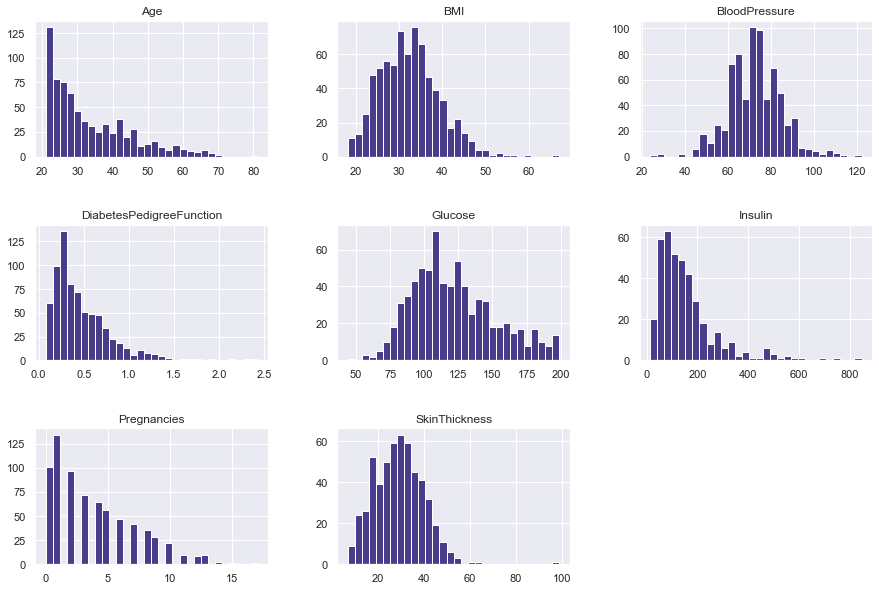

In [15]:
# Let's create histograms to see what the distribution looks and look for outliers
sns.set()
df_dw.loc[:, df_dw.columns != 'Outcome'].hist(figsize=(15,10), bins=30, color='darkslateblue')
plt.subplots_adjust(hspace=0.5)
fig_path = os.path.join(plot_path, 'feat_dist.png')
plt.savefig(fig_path, dpi=300);

**Age** Looks reasonable.<br>**BMI** There are some outliers on the high end but it appears generally normal.<br>**Blood Pressure** May be some outliers on the low end.<br>**DiabetesPedigreeFunction** This appears exponentially distributed in which case it will be difficult to identifier outliers.<br>**Glucose** This data looks like it's skewed to the right a bit but there don't appear to be outliers.<br>**Insulin** There appear to be some real outliers.<br>**Pregnancies** Looks a bit like it's an exponential distribution which intuitively makes sense.<br>**SkinThickness** There seem to be some outliers on the high end but it appears generally normal.

In [16]:
# We'll define a function to return outliers for a series based on IQR
def return_outliers(S):
    """" returns outliers in a series based on elements being > 1.5*IQR above 3rd quartile
    or 1.5*IQR below 1st quartile """
    
    # Calculate 1st and 3rd quartiles and IQR
    p_25 = np.percentile(S, 25)
    p_75 = np.percentile(S, 75)
    iqr = p_75 - p_25

    # return outliers
    return S[((S>(1.5*iqr + p_75)) | (S<(p_25 - 1.5*iqr)))]

In [17]:
# Calculating outlers based on IQR really only makes sense for nomal distributions, so we'll
# apply this function to BMI, Skin Thickness, and Blood Pressure.
# Note that Insulin and Diabetes Pedigree Function appear to be exponentially distributed.

# Let's identify outliers based on the IQR for BMI and Skin Thickness
print('BMI Outliers: \n', \
      return_outliers(df_dw[df_dw['BMI'].notnull()]['BMI']).sort_values(ascending=False),"\n")
print('SkinThickness: \n', \
      return_outliers(df_dw[df_dw['SkinThickness'].notnull()]['SkinThickness']).sort_values(ascending=False),"\n")
print('BloodPressure: \n', \
      return_outliers(df_dw[df_dw['BloodPressure'].notnull()]['BloodPressure']).sort_values(ascending=False),"\n")

BMI Outliers: 
 177    67.1
445    59.4
673    57.3
125    55.0
120    53.2
303    52.9
247    52.3
Name: BMI, dtype: float64 

SkinThickness: 
 579    99.0
445    63.0
57     60.0
Name: SkinThickness, dtype: float64 

BloodPressure: 
 106    122.0
691    114.0
549    110.0
177    110.0
43     110.0
362    108.0
84     108.0
672    106.0
662    106.0
658    106.0
599     38.0
125     30.0
18      30.0
597     24.0
Name: BloodPressure, dtype: float64 



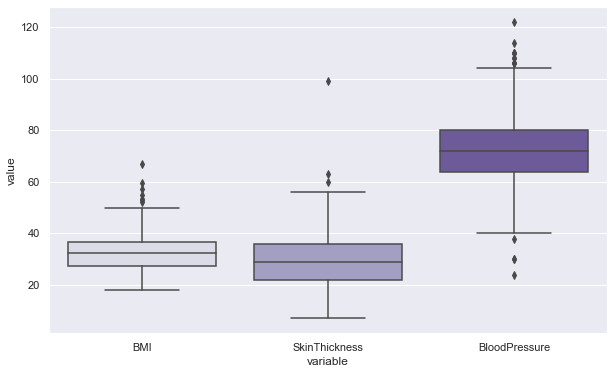

In [18]:
#Let's also visualize this using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(df_dw[['BMI','SkinThickness','BloodPressure']]), palette='Purples')
fig_path = os.path.join(plot_path, 'outliers.png')
plt.savefig(fig_path, dpi=300);
plt.show()

I am hesitant to remove these outliers because it's not clear that they are actually invalid data, and we don't have a lot of data to start with.  We know that logistic regression is susceptible to outliers but random forest not so much. Perhaps we run our models, and then we come back to this step later on and remove outliers and rerun the models and see if this makes a difference.

Other things we could try:

Winsorizing: This method involves setting the extreme values of an attribute to some specified value. For example, for a 90% Winsorization, the bottom 5% of values are set equal to the minimum value in the 5th percentile, while the upper 5% of values are set equal to the maximum value in the 95th percentile. This is more advanced than trimming where we just exclude the extreme values. This approach might make sense for the three attributes above.  

Log-Scale Transformation: This method is often used to reduce the variability of data including outlying observation. Here, the y value is changed to log(y). It’s often preferred when the response variable follows exponential distribution or is right-skewed. This would make sense for Insulin and DiabetesPedigreeFunction. 

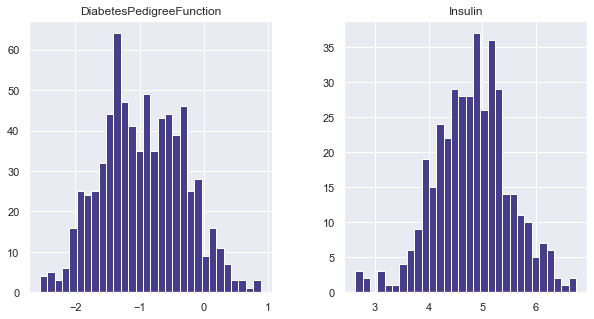

In [19]:
#Let's try a log scale transformation on Insulin and Diabetes Pedigree Function
log_insulin = np.log(df_dw[['Insulin','DiabetesPedigreeFunction']])
_ = log_insulin.hist(figsize=(10,5), bins=30, color='darkslateblue')

These distributions look much more normal now and don't appear to have real outliers, so it may make sense to transform them before putting them into our logistic regression model.  

So for now, I'm making the decision to not remove any outliers.  

## Categorization of BMI
BMI is often categorized, so let's add a column to our dataframe based on the following categories:<br>
< 18.5	underweight<br>
18.5–24.9	normal weight<br>
25.0–29.9	overweight<br>
30.0–34.9	class I obesity<br>
35.0–39.9	class II obesity<br>
≥ 40.0	class III obesity<br>

In [20]:
bmi_bins = [0,18.5,25,30,35,40,100]
bmi_labels = ['Underweight','Normal Weight','Overweight','Class I Obese','Class II Obese','Class III Obese']
df_dw['BMI Category'] = pd.cut(df_dw['BMI'],bins = bmi_bins, labels = bmi_labels)

In [21]:
df_dw['BMI Category'].dtype

CategoricalDtype(categories=['Underweight', 'Normal Weight', 'Overweight',
                  'Class I Obese', 'Class II Obese', 'Class III Obese'],
                 ordered=True)

We can see from this that the attributes which show the highest correlation are age and number of pregnancies (makes sense), and Skin Thickness and BMI (also makes sense).  However the correlation coefficient for these isn't much higher than 0.6, so I don't think that will be a problem for our logistic regression model.  Note that the number of pregnancies shows a very low correlation with several attributes, which makes sense.  Overall I think this heatmap looks pretty good because we don't see a lot of collinearity between our attributes.  

## Balance of Outcome

In [22]:
# Lets look at distribution of Outcome
df_dw['Outcome'].value_counts()

0    481
1    252
Name: Outcome, dtype: int64

We've got about a third of the instances with positive outcomes, which is somewhat imbalanced but not terribly imbalanced. For now we'll just stay aware of this and see how our models do, but there are tools at our disposal, such as SMOTE, to help us address this and perhaps increase the accuracy of our models.

## Save Data

In [23]:
# We're going to save our final dataframe to a csv file,
# and also save a config file which lets us know a bit 
# about what we've done here.

datapath = '../data'
datapath_dw = os.path.join(datapath, 'df_dw.csv')
df_dw.to_csv(datapath_dw, index=False)